# Before you start with this Notebook

This notebook is a sample for using Mlflow with Vectice. It illustrates how to use Mlflow with Vectice.

### Pre-requisites:
Before using this notebook you will need:
* An account in Vectice
* An API key to connect to Vectice through the APIs
* The Phase Id of the project where you want to log your work

Refer to Vectice Tutorial Guide for more detailed instructions: https://docs.vectice.com/getting-started/tutorial


### Other Resources
*   Vectice Documentation: https://docs.vectice.com/ </br>
*   Vectice API documentation: https://api-docs.vectice.com/

In [ ]:
import os
import vectice
from vectice import connect, Dataset, DatasetType, Model
import pandas as pd
import numpy as np
import mlflow
from mlflow import MlflowClient
import matplotlib.pyplot as plt

## Get started by connecting to Vectice

You can learn more about the `Connection` object in the [documentation](https://api-docs.vectice.com/reference/vectice/connection/)

**First, we need to authenticate to the Vectice server. Before proceeding further:**

- Visit the Vectice app to create and copy an API key (cf. https://docs.vectice.com/getting-started/create-an-api-key)

- Paste the API key in the code below

In [ ]:
connect = vectice.connect(api_token="your_api_key")

In [ ]:
# create an iteration inside the phase you want to work on
iteration = connect.phase("PHA-xxxx").create_iteration()

## Existing MLflow Model
- Only the run id is required 
- All Models' metadata is logged in Vectice

In [ ]:
from mlflow import MlflowClient
import mlflow

mlflow.set_tracking_uri('http://localhost:5000')

In [ ]:
client = MlflowClient()

### MLflow Run ID
- The run id is required, this can be found in the Models tab by drilling down and selecting a version

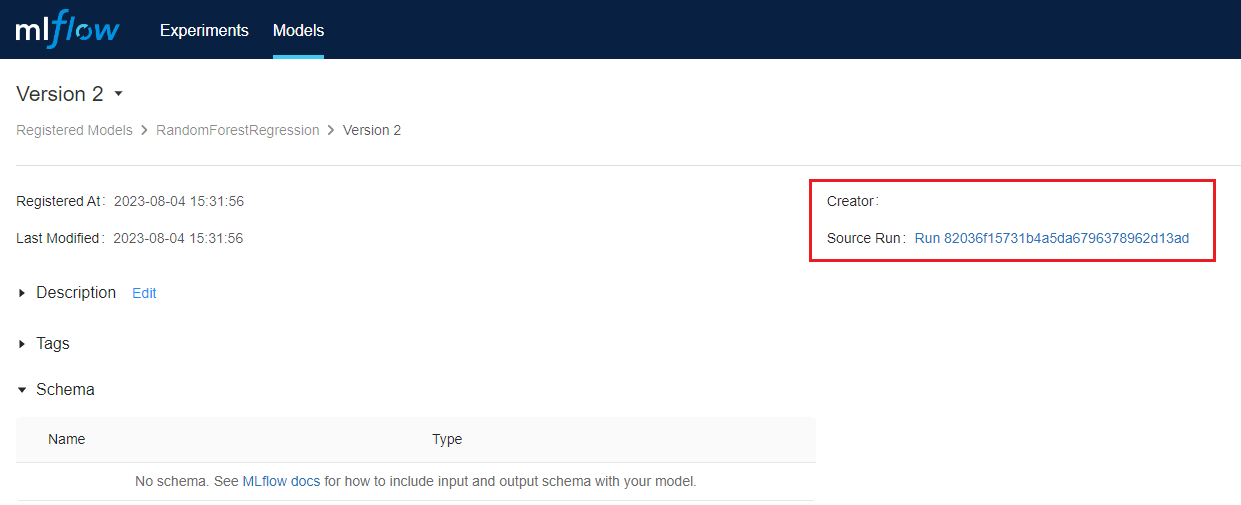

In [ ]:
# The run id from the MLflow UI
run_id = "36d7c3872da54d68bfe5cb2255628e2c"

In [ ]:
model = Model.mlflow(run_id=run_id, client=mlflow)
# Pass the model to the Vectice Iteration Step, the step here is 'step_collect_initial_data'
iteration.log(model)

## Current Model
- Log the current experiment by using the run id 
- The run id can be accessed via the started run

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

mlflow.set_tracking_uri('http://localhost:5000')


experiment_id = mlflow.create_experiment('experiment_name')

data = pd.read_csv('data_path')
train, test = train_test_split(data, test_size=0.3, random_state=1)

# The predicted column is "quality" which is a multiclass target variable
X_train, X_test = train.drop(["quality"], axis=1), test.drop(["quality"], axis=1)
y_train, y_test = train["quality"], test["quality"]

with mlflow.start_run(run_name='mlFlow_test', experiment_id=experiment_id) as run:
    # Start mlflow session
    run_id = run.info.run_uuid
    
    # Log hyperparameters
    mlflow.log_param("penalty", 'l2')
    mlflow.log_param("C", 1.0)
    mlflow.log_param("solver", 'lbfgs')

    # Create and fit model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Log metrics
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    
    # Log the model as an MLflow model
    mlflow.sklearn.log_model(model, 'model_name')

In [ ]:
# Pass the run ID and mlflow client to log the model 
model = Model.mlflow(run_id=run_id, client=mlflow, derived_from='DTV-xxxx')
# Pass the model to the iterations' step 
iteration.log(model)